# Quantization Aware Training (QAT)

References:

- [Quantization (PyTorch documentation)](https://pytorch.org/docs/stable/quantization.html)
- [`train_quantization.py` (Torchvision reference code)](https://github.com/pytorch/vision/blob/main/references/classification/train_quantization.py)

In [1]:
import os
import sys
from pathlib import Path

import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader

sys.path.append(os.fspath(Path.cwd().parent.resolve()))

In [2]:
from anime4k_torch.data import NpyDataset, transform_image_train, transform_image_eval
from anime4k_torch.metric import yuv_error
from anime4k_torch.model import SR2Model
from anime4k_torch.training import eval_loop, train_loop
from anime4k_torch.visualization import show_images

In [3]:
data_dir = Path("../../data/synla").resolve()
dataloader_config = {"batch_size": 32, "num_workers": 8, "pin_memory": True}

train_set = NpyDataset(data_dir / "synla_4096.npy", transform_image_train)
train_loader = DataLoader(train_set, shuffle=True, drop_last=True, **dataloader_config)

validation_set = NpyDataset(data_dir / "synla_1024.npy", transform_image_eval)
validation_loader = DataLoader(validation_set, **dataloader_config)

In [4]:
checkpoint_dir = Path("../checkpoints").resolve()
checkpoint_dir.mkdir(exist_ok=True)

Use the "onednn" backend because the default "x86" does not seem to use the full 8 bits ([reference](https://pytorch.org/docs/stable/quantization.html#best-practices)).

Base learning rates: 1e4, 1e-3, 1e-4

| Learning Rates | Validation Losses |   |   |
| -------------- | ----------------- | - | - |
| x1  | 0.00200 | 0.00179 | 0.00147 |
| x4  | 0.00172 | 0.00127 | 0.00122 |
| x8  | 0.00144 | 0.00118 | 0.00115 |
| x10 | 0.00143 | 0.00119 | 0.00115 |
| x16 | 0.00135 | 0.00120 | 0.00114 |
| x20 | 0.00132 | 0.00119 | 0.00114 |

In [5]:
qconfig = torch.ao.quantization.get_default_qat_qconfig("onednn")
model = SR2Model(highway_depth=4, block_depth=7, qconfig=qconfig)
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
model.to(device)

# TODO: Fuse conv and relu operations.

model = torch.ao.quantization.prepare_qat(model)
train_losses = []

# Super-convergence with clipping
optimizer = SGD(model.parameters(), lr=1e5, momentum=0.9, nesterov=True)
train_losses.extend(
    train_loop(
        model, optimizer, yuv_error, train_loader, epochs=32, clip_grad_norm=1e-8
    )
)
validation_loss = eval_loop(model, yuv_error, validation_loader)
print("Validation loss:", validation_loss)

# Fine tuning with Adam
clip_grad_norm = None
for learning_rate in 1e-2, 1e-3:
    optimizer = Adam(model.parameters(), learning_rate)
    train_losses.extend(
        train_loop(
            model,
            optimizer,
            yuv_error,
            train_loader,
            epochs=64,
            clip_grad_norm=clip_grad_norm,
        )
    )
    validation_loss = eval_loop(model, yuv_error, validation_loader)
    print("Validation loss:", validation_loss)

with torch.inference_mode():
    model.cpu()
    model.eval()
    model = torch.ao.quantization.convert(model)
    torch.save(model.state_dict(), checkpoint_dir / "synla_i8.pth")

Training epoch 1/32:   0%|          | 0/4096 [00:00<?, ?it/s, epoch_loss=N/A, batch_loss=N/A]/home/yunhao/miniforge3/envs/anime4k_torch/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/home/yunhao/miniforge3/envs/anime4k_torch/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/native/TensorCompare.cpp:677.)
  return torch.fused_moving_avg_obs_fake_quant(
Evaluation: 100

Validation loss: 0.0014323572831926867


Evaluation: 100%|██████████| 32/32 [00:00<00:00, 66.41it/s, batch_loss=0.00106]


Validation loss: 0.0011863837971759494


Evaluation: 100%|██████████| 32/32 [00:00<00:00, 69.79it/s, batch_loss=0.00102] 


Validation loss: 0.0011523702742124442


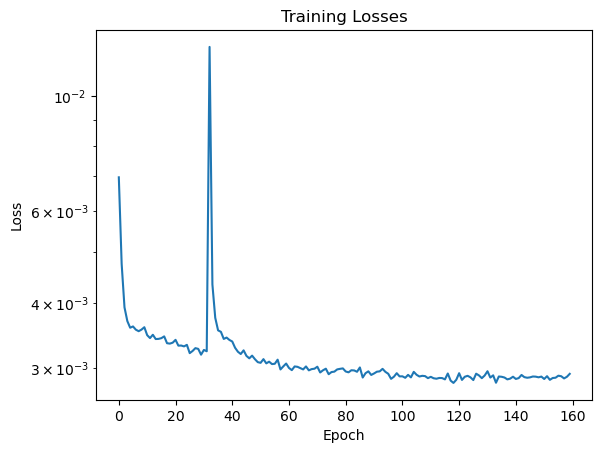

In [6]:
plt.plot(train_losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
None  # Suppress output.

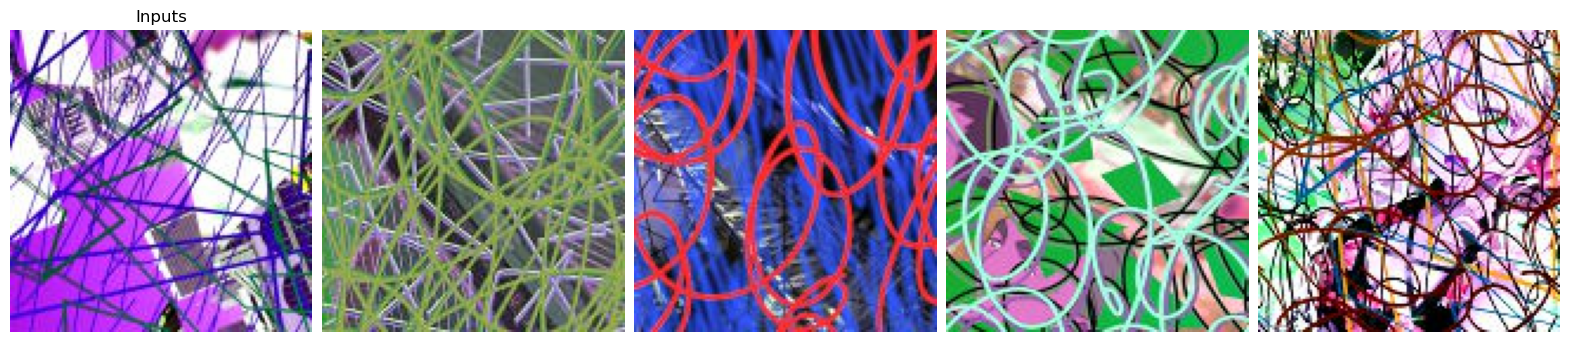

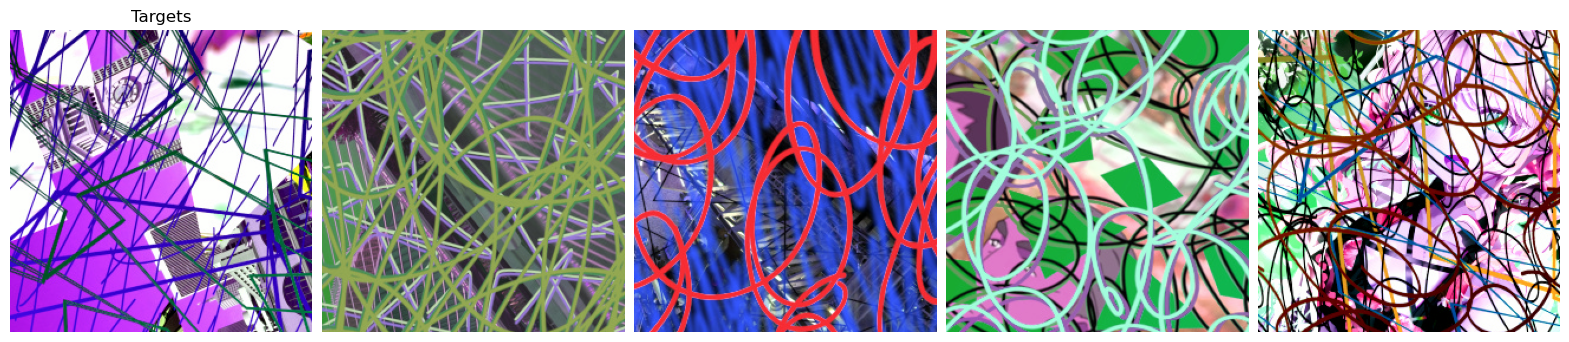

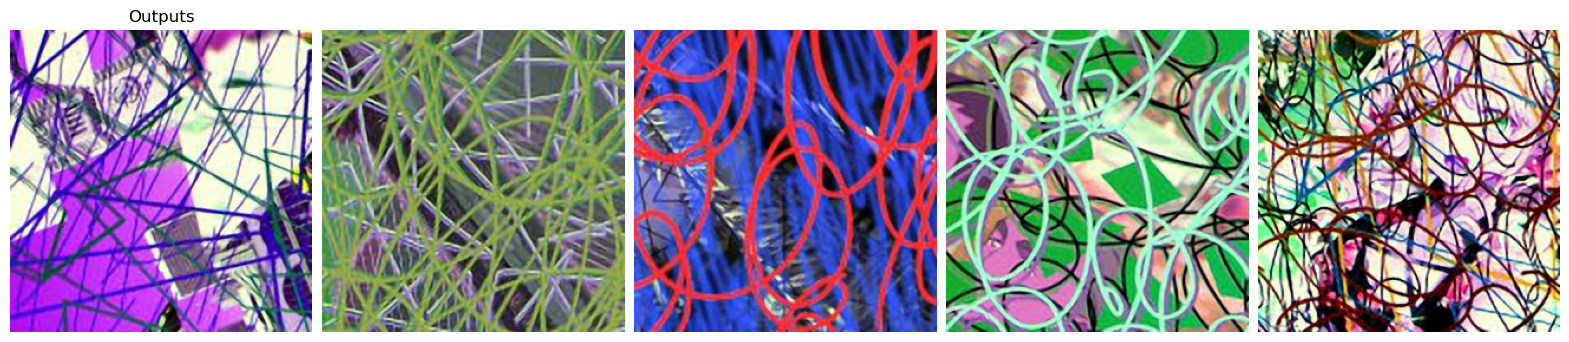

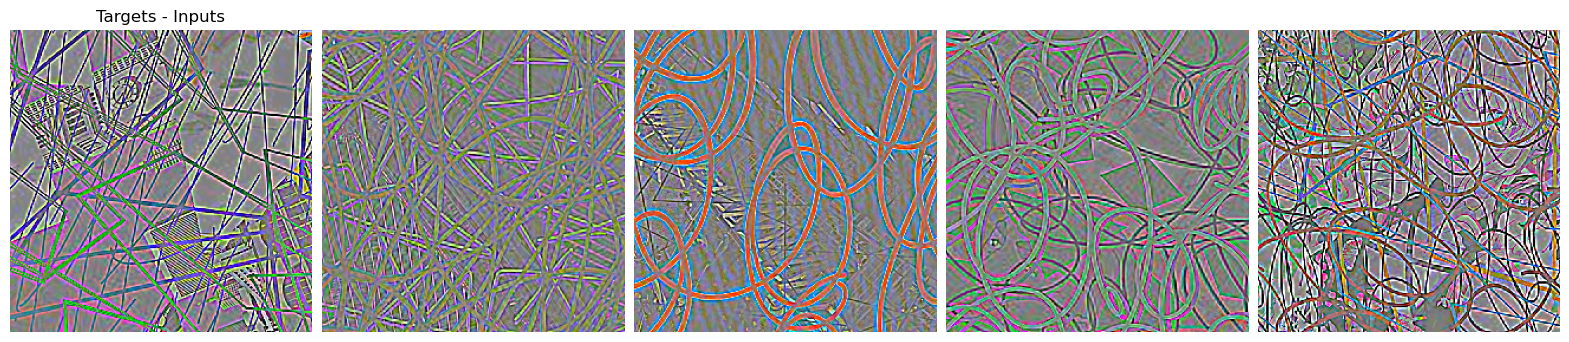

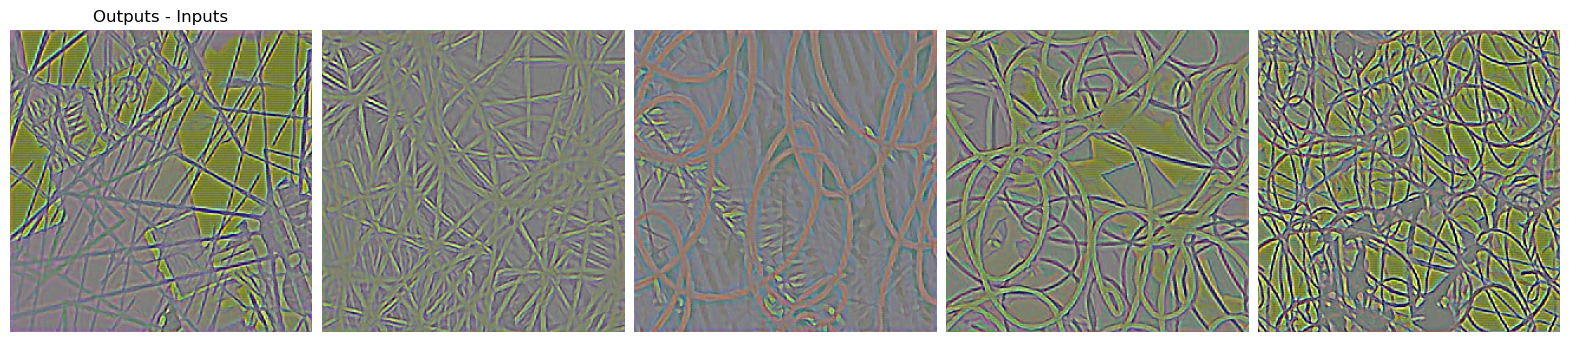

In [7]:
figsize = (20, 20)

with torch.inference_mode():
    inputs, targets = next(iter(DataLoader(train_set, batch_size=5)))
    model.eval()
    outputs = model(inputs)

figure = plt.figure(figsize=figsize)
show_images(figure, inputs)
figure.axes[0].set_title("Inputs")

figure = plt.figure(figsize=figsize)
show_images(figure, targets)
figure.axes[0].set_title("Targets")

figure = plt.figure(figsize=figsize)
show_images(figure, outputs)
figure.axes[0].set_title("Outputs")

upsampled_inputs = F.interpolate(inputs, scale_factor=2, mode="bilinear")

figure = plt.figure(figsize=figsize)
show_images(figure, targets - upsampled_inputs, value_range=(-0.2, 0.2))
figure.axes[0].set_title("Targets - Inputs")

figure = plt.figure(figsize=figsize)
show_images(figure, outputs - upsampled_inputs, value_range=(-0.2, 0.2))
figure.axes[0].set_title("Outputs - Inputs")

None  # Suppress output.